In [122]:
BENCHMARK_TOOL = 'NVPROF' # or 'NCU'

import subprocess
import numpy as np
import pandas as pd
import io
from matplotlib import pyplot as plt 
from typing import Tuple

In [123]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame, kernelNum=0) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        # conversion en ms 
        if df.loc[0, 'Duration'] == "ms":
            return float(df.loc[kernelNum + 1, 'Duration']) 
        if df.loc[0, 'Duration'] == "s":
            return float(df.loc[kernelNum + 1, 'Duration']) * 1e3
        # probablement en micro seconde
        return float(df.loc[kernelNum + 1, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [124]:
"""kernelDurations = []
numberOfKernel = 5

for i in range(0, numberOfKernel):
    kernelDurations.append(
        get_kernel_duration(
            read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(i))), i
        ) # * 1e3
    )
print("Durée de chaque kernel:")
print(kernelDurations) # En milliseconde

print("benchmark du kernel RGB To HSV:")
read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(0))) 
"""

Durée de chaque kernel:
[0.160063, 1.823894, 6.109025, 0.014432, 5.02653]


In [127]:
# Renvoie les durée moyennes en fonction de variation de tailles de l'axe X des blocs pour un certain kernel
def evaluateBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
    avg = 0
    xBlockSize, yBlockSize = 1, 1

    while xBlockSize <= 1024:
        for _ in range(nTry) :         
            avg += get_kernel_duration(read_benchmark(
                benchmark_kernel("./hist", 
                    "-f", "./img/chateau.png", 
                    "-b", str(kernelType), 
                    "-d", str(xBlockSize), str(yBlockSize)
                )
            ), kernelType)

        avg /= nTry
        durations.append(avg)    
        sizes.append(xBlockSize)
        xBlockSize *= 2
    return durations, sizes

 


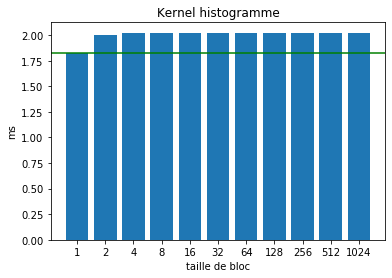

In [138]:
def showHistogramDuration(durations, sizes, title, xLabel, yLabel):
    plt.title(title)  
    plt.xlabel(xLabel) 
    plt.ylabel(yLabel) 
    plt.bar(np.array(sizes).astype(str), np.array(durations), width=.8)
    plt.axhline(min(durations), ls='-', color='green')
    plt.show()

def showHistogramOfKernels(kernels, titles):  
    for k, title in zip(kernels, titles):
        durations, sizes = evaluateBlocSize(3)
        showHistogramDuration(durations, sizes, title, "taille de bloc", "ms") 
 
print("Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X") 
showHistogramOfKernels([
    0, 3
], [
    "rgb2hsv", "histogram"
])

In [1]:
def evaluate2DBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
     
    xBlockSize = 1

    while xBlockSize <= 1024:
        yBlockSize = 1
        durations.append([])
        while yBlockSize <= 1024:
            avg = 0
            for _ in range(nTry) :         
                avg += get_kernel_duration(read_benchmark(
                    benchmark_kernel("./hist", 
                        "-f", "./img/chateau.png", 
                        "-b", str(kernelType), 
                        "-d", str(xBlockSize), str(yBlockSize)
                    )
                ), kernelType)

            avg /= nTry
            durations[-1].append(avg)    
            sizes.append(xBlockSize)
            yBlockSize *= 2
        xBlockSize *= 2
    return durations, sizes


def showHistogramDuration3D(durations, sizesX, sizesY, title, dLabel, xLabel, yLabel): 
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(sizesX, sizesY)   
    surf = ax.plot_surface(X, Y, np.array(durations), cmap=cm.coolwarm,
        linewidth=0, antialiased=False)

    # Customize the z axis. 
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    ax.legend()
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel(dLabel)
    # Add a color bar which maps values to colors.
    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

durations, sizes = evaluate2DBlocSize(3)
showHistogramDuration3D(durations, sizes, sizes, "Variation de la taille des blocs", "durée (en ms)", "taille x", "taille y")

NameError: name 'get_kernel_duration' is not defined